# Stage 12 — Results Reporting, Delivery Design & Stakeholder Communication

In [1]:
import numpy as np, pandas as pd
np.random.seed(12)
RANDOM_STATE = 12

In [2]:

# Data: synthetic segmented daily data
import pandas as pd, numpy as np
n_days = 365
dates = pd.date_range("2024-01-01", periods=n_days, freq="D")
segments = ["A","B","C"]
price_base = {"A":15.0,"B":18.0,"C":22.0}
unit_cost = {"A":9.0,"B":11.0,"C":13.0}
vol_base = {"A":200,"B":140,"C":100}
rows=[]
for d in dates:
    season = 1.0 + 0.1*np.sin(2*np.pi*(d.dayofyear/365.0))
    for s in segments:
        price = price_base[s]*(1.0+0.01*np.sin(2*np.pi*(d.dayofyear/30.0)))
        vol = np.random.poisson(lam=vol_base[s]*season)
        revenue = price*vol
        cost = unit_cost[s]*vol*np.random.normal(1.0,0.02)
        profit = revenue - cost
        rows.append({"date":d,"segment":s,"price":price,"volume":vol,"revenue":revenue,"cost":cost,"profit":profit})
df = pd.DataFrame(rows).set_index("date").sort_index()
df.head()


,segment,price,volume,revenue,cost,profit
date,,,,,,
2024-01-01,A,15.031187,184,2765.738363,1664.029596,1101.708767
2024-01-01,B,18.037424,158,2849.913008,1678.882429,1171.030579
2024-01-01,C,22.045741,125,2755.717571,1649.477142,1106.240429
2024-01-02,A,15.061010,203,3057.385131,1770.921282,1286.463849
2024-01-02,B,18.073213,150,2710.981889,1686.166552,1024.815337


In [3]:

# Aggregations for plots
import matplotlib.pyplot as plt
monthly = df.groupby([pd.Grouper(freq="M")]).agg({"revenue":"sum","profit":"sum"})
by_segment = df.groupby("segment").agg({"revenue":"sum","profit":"sum","volume":"sum"})
risk_return = df.groupby("segment").agg(mean_profit=("profit","mean"), risk=("profit","std")).reset_index()


/var/folders/dj/t_cw33ws3lb2m3y9lb4jtk640000gn/T/ipykernel_60967/3954670910.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.groupby([pd.Grouper(freq="M")]).agg({"revenue":"sum","profit":"sum"})


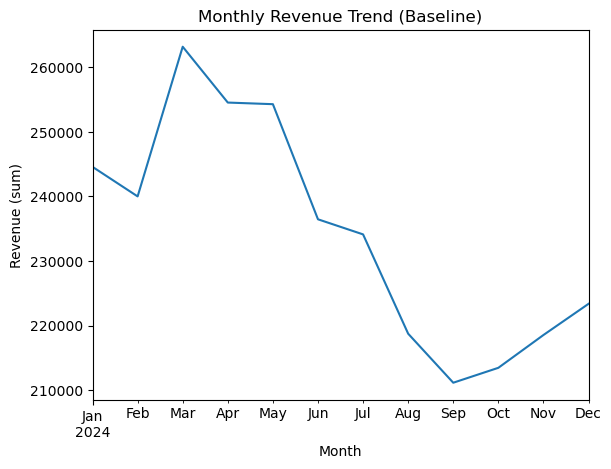

In [4]:

# Line: monthly revenue
plt.figure()
monthly["revenue"].plot()
plt.title("Monthly Revenue Trend (Baseline)")
plt.xlabel("Month"); plt.ylabel("Revenue (sum)")
plt.show()


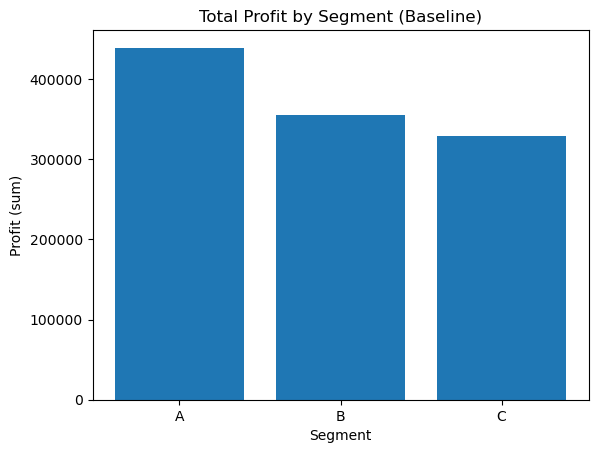

In [5]:

# Bar: profit by segment
plt.figure()
plt.bar(by_segment.index, by_segment["profit"].values)
plt.title("Total Profit by Segment (Baseline)")
plt.xlabel("Segment"); plt.ylabel("Profit (sum)")
plt.show()


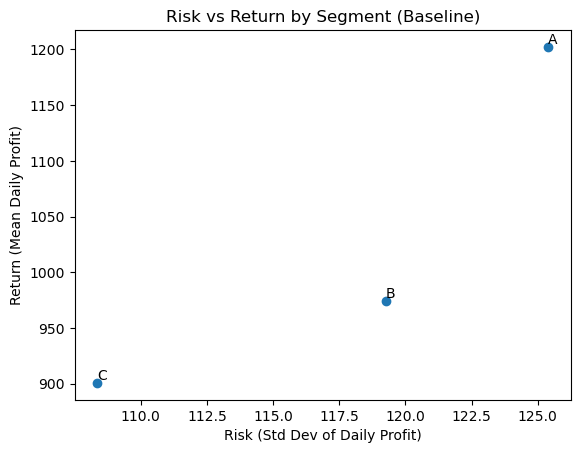

In [6]:

# Scatter: risk vs return
plt.figure()
plt.scatter(risk_return["risk"], risk_return["mean_profit"])
for _, r in risk_return.iterrows():
    plt.text(r["risk"], r["mean_profit"], r["segment"], ha="left", va="bottom")
plt.title("Risk vs Return by Segment (Baseline)")
plt.xlabel("Risk (Std Dev of Daily Profit)"); plt.ylabel("Return (Mean Daily Profit)")
plt.show()


## Sensitivity: scenario (price −5% with elasticity; unit cost +2%) and tornado analysis

In [7]:

ELASTICITY = -1.5
PRICE_CHANGE = -0.05
COST_INFL = 0.02

df_scen = df.reset_index().copy()
df_scen["price_s"] = df_scen["price"]*(1.0+PRICE_CHANGE)
df_scen["volume_s"] = (df_scen["volume"]*(1.0 + (-PRICE_CHANGE)*(-ELASTICITY))).astype(int).clip(lower=0)
unit_cost_est = (df["cost"]/df["volume"]).replace([np.inf,-np.inf], np.nan).fillna(method="ffill").fillna(method="bfill")
df_scen["unit_cost_s"] = unit_cost_est.values*(1.0+COST_INFL)
df_scen["revenue_s"] = df_scen["price_s"]*df_scen["volume_s"]
df_scen["cost_s"] = df_scen["unit_cost_s"]*df_scen["volume_s"]
df_scen["profit_s"] = df_scen["revenue_s"] - df_scen["cost_s"]
df_scen = df_scen.set_index("date").sort_index()

sum_base = df[["revenue","profit"]].sum().rename(lambda x: f"{x}_base")
sum_scen = df_scen[["revenue_s","profit_s"]].sum().rename(lambda x: x.replace("_s","_scen"))


/var/folders/dj/t_cw33ws3lb2m3y9lb4jtk640000gn/T/ipykernel_60967/1806122434.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  unit_cost_est = (df["cost"]/df["volume"]).replace([np.inf,-np.inf], np.nan).fillna(method="ffill").fillna(method="bfill")


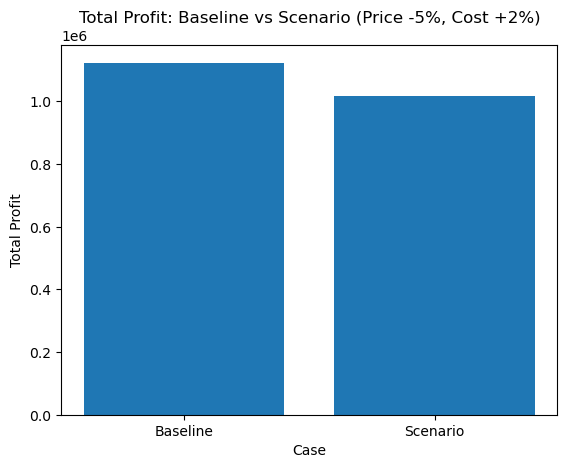

In [8]:

# Baseline vs scenario profit chart
import matplotlib.pyplot as plt
plt.figure()
plt.bar(["Baseline","Scenario"], [sum_base["profit_base"], sum_scen["profit_scen"]])
plt.title("Total Profit: Baseline vs Scenario (Price -5%, Cost +2%)")
plt.xlabel("Case"); plt.ylabel("Total Profit")
plt.show()


/var/folders/dj/t_cw33ws3lb2m3y9lb4jtk640000gn/T/ipykernel_60967/227258847.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  unit_cost_est = (df["cost"]/df["volume"]).replace([np.inf,-np.inf], np.nan).fillna(method="ffill").fillna(method="bfill").values
/var/folders/dj/t_cw33ws3lb2m3y9lb4jtk640000gn/T/ipykernel_60967/227258847.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  unit_cost_est = (df["cost"]/df["volume"]).replace([np.inf,-np.inf], np.nan).fillna(method="ffill").fillna(method="bfill").values
/var/folders/dj/t_cw33ws3lb2m3y9lb4jtk640000gn/T/ipykernel_60967/227258847.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  unit_cost_est = (df["cost"]/df["volume"]).replace([np.inf,-np.inf], np.nan).fillna(method="

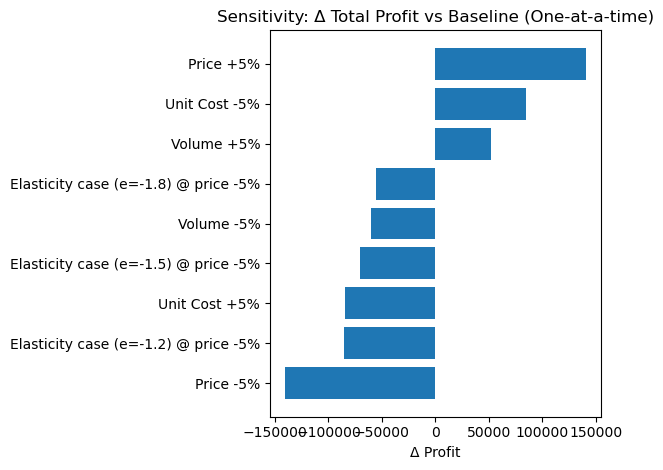

In [9]:

# Tornado one-at-a-time
baseline_total_profit = df["profit"].sum()
def total_profit_with(price_mult=1.0, volume_mult=1.0, cost_mult=1.0, elasticity=None):
    tmp = df.reset_index().copy()
    tmp["price_t"] = tmp["price"]*price_mult
    if elasticity is not None and price_mult!=1.0:
        pct_price = price_mult-1.0
        vol_mult = 1.0 + (-pct_price)*(-elasticity)
    else:
        vol_mult = volume_mult
    tmp["volume_t"] = (tmp["volume"]*vol_mult).astype(int).clip(lower=0)
    unit_cost_est = (df["cost"]/df["volume"]).replace([np.inf,-np.inf], np.nan).fillna(method="ffill").fillna(method="bfill").values
    tmp["unit_cost_t"] = unit_cost_est*cost_mult
    tmp["revenue_t"] = tmp["price_t"]*tmp["volume_t"]
    tmp["cost_t"] = tmp["unit_cost_t"]*tmp["volume_t"]
    tmp["profit_t"] = tmp["revenue_t"] - tmp["cost_t"]
    return tmp["profit_t"].sum()

rows=[]
for mult,label in [(0.95,"Price -5%"),(1.05,"Price +5%")]:
    prof = total_profit_with(price_mult=mult, elasticity=None)
    rows.append((label, prof - baseline_total_profit))
for mult,label in [(0.95,"Volume -5%"),(1.05,"Volume +5%")]:
    prof = total_profit_with(volume_mult=mult)
    rows.append((label, prof - baseline_total_profit))
for mult,label in [(0.95,"Unit Cost -5%"),(1.05,"Unit Cost +5%")]:
    prof = total_profit_with(cost_mult=mult)
    rows.append((label, prof - baseline_total_profit))
for e in [-1.2,-1.5,-1.8]:
    prof = total_profit_with(price_mult=0.95, elasticity=e)
    rows.append((f"Elasticity case (e={e}) @ price -5%", prof - baseline_total_profit))

import pandas as pd
tornado_df = pd.DataFrame(rows, columns=["assumption","delta_profit"]).sort_values("delta_profit")

import matplotlib.pyplot as plt
plt.figure()
plt.barh(tornado_df["assumption"], tornado_df["delta_profit"])
plt.title("Sensitivity: Δ Total Profit vs Baseline (One-at-a-time)")
plt.xlabel("Δ Profit")
plt.tight_layout()
plt.show()


In [10]:
# Ensure output folders exist
from pathlib import Path
IMG_DIR = Path("deliverables/images")
IMG_DIR.mkdir(parents=True, exist_ok=True)

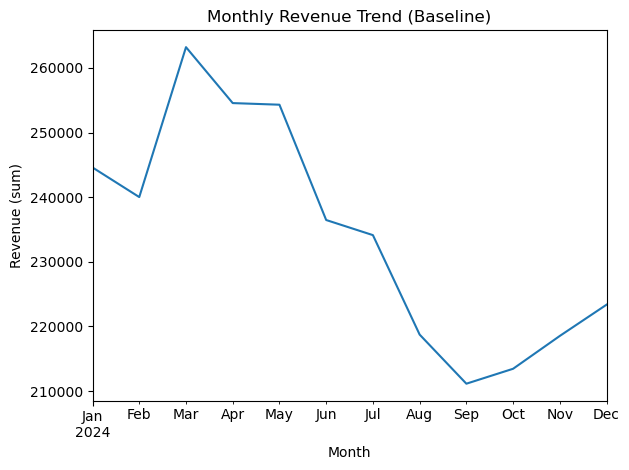

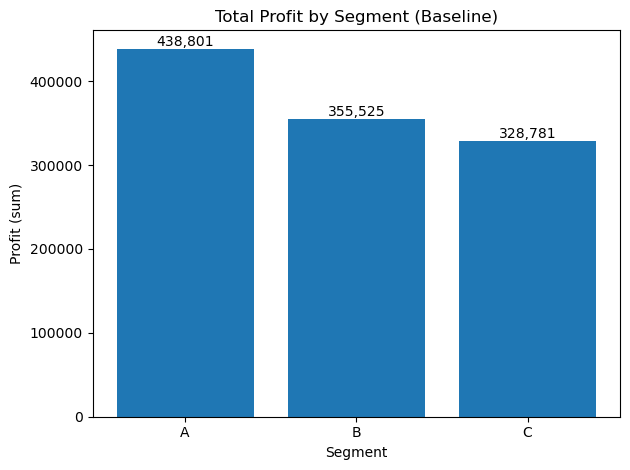

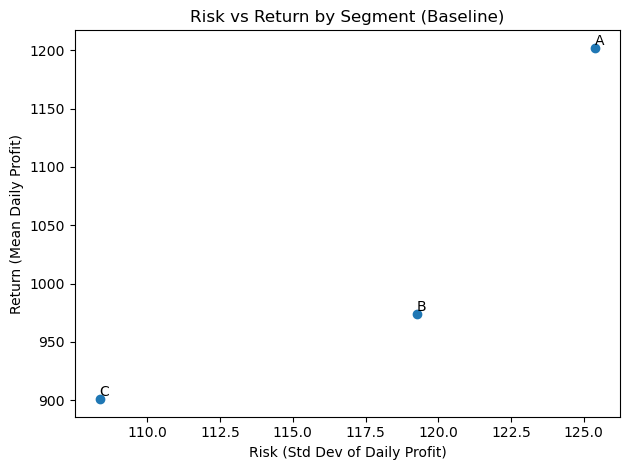

In [11]:
# === Stage 12: Key plots & PNG export ===
import matplotlib.pyplot as plt

# 1) Line: Monthly revenue trend
plt.figure()
monthly["revenue"].plot()
plt.title("Monthly Revenue Trend (Baseline)")
plt.xlabel("Month"); plt.ylabel("Revenue (sum)")
plt.tight_layout()
plt.savefig((IMG_DIR/"line_monthly_revenue.png").as_posix(), bbox_inches="tight", dpi=160)
plt.show()

# 2) Bar: Total profit by segment
plt.figure()
plt.bar(by_segment.index, by_segment["profit"].values)
for i, v in enumerate(by_segment["profit"].values):
    plt.text(i, v, f"{v:,.0f}", ha="center", va="bottom")  # brief annotation
plt.title("Total Profit by Segment (Baseline)")
plt.xlabel("Segment"); plt.ylabel("Profit (sum)")
plt.tight_layout()
plt.savefig((IMG_DIR/"bar_profit_by_segment.png").as_posix(), bbox_inches="tight", dpi=160)
plt.show()

# 3) Scatter: Risk (σ of profit) vs Return (mean profit) by segment
plt.figure()
plt.scatter(risk_return["risk"], risk_return["mean_profit"])
for _, r in risk_return.iterrows():
    plt.text(r["risk"], r["mean_profit"], r["segment"], ha="left", va="bottom")
plt.title("Risk vs Return by Segment (Baseline)")
plt.xlabel("Risk (Std Dev of Daily Profit)"); plt.ylabel("Return (Mean Daily Profit)")
plt.tight_layout()
plt.savefig((IMG_DIR/"scatter_risk_return.png").as_posix(), bbox_inches="tight", dpi=160)
plt.show()


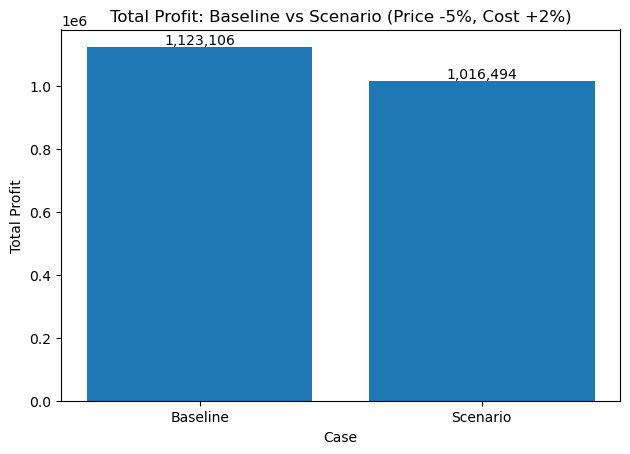

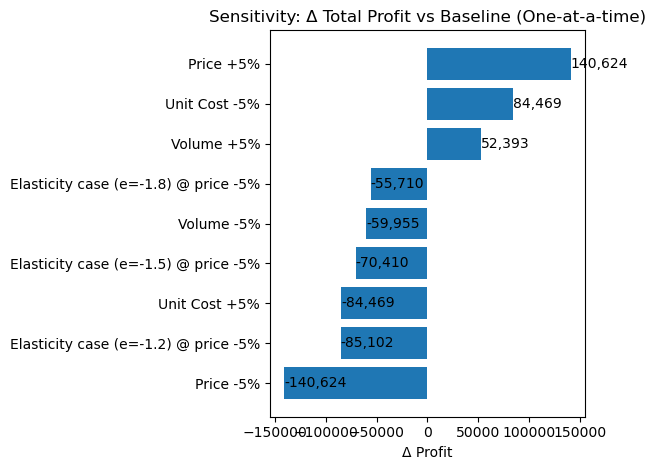

In [12]:
# === Stage 12: Sensitivity analysis & PNG export ===
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

SENS_CSV = Path("deliverables/sensitivity_summary.csv")

# Scenario: price −5% with elasticity-driven volume lift; unit cost +2%
ELASTICITY = -1.5
PRICE_CHANGE = -0.05   # -5%
COST_INFL = 0.02       # +2%

df_scen = df.reset_index().copy()
df_scen["price_s"] = df_scen["price"] * (1.0 + PRICE_CHANGE)
df_scen["volume_s"] = (df_scen["volume"] * (1.0 + (-PRICE_CHANGE)*(-ELASTICITY))).astype(int).clip(lower=0)

# Estimate unit cost per unit from baseline and inflation it
unit_cost_est = (df["cost"]/df["volume"]).replace([np.inf,-np.inf], np.nan).ffill().bfill()
df_scen["unit_cost_s"] = unit_cost_est.values * (1.0 + COST_INFL)

df_scen["revenue_s"] = df_scen["price_s"] * df_scen["volume_s"]
df_scen["cost_s"]    = df_scen["unit_cost_s"] * df_scen["volume_s"]
df_scen["profit_s"]  = df_scen["revenue_s"] - df_scen["cost_s"]
df_scen = df_scen.set_index("date").sort_index()

sum_base = df[["revenue","profit"]].sum().rename(lambda x: f"{x}_base")
sum_scen = df_scen[["revenue_s","profit_s"]].sum().rename(lambda x: x.replace("_s","_scen"))
sens_summary = pd.concat([sum_base, sum_scen], axis=0).to_frame("value").reset_index().rename(columns={"index":"metric"})
sens_summary.to_csv(SENS_CSV, index=False)

# Figure: Baseline vs Scenario total profit
plt.figure()
plt.bar(["Baseline","Scenario"], [sum_base["profit_base"], sum_scen["profit_scen"]])
for i, v in enumerate([sum_base["profit_base"], sum_scen["profit_scen"]]):
    plt.text(i, v, f"{v:,.0f}", ha="center", va="bottom")
plt.title("Total Profit: Baseline vs Scenario (Price -5%, Cost +2%)")
plt.xlabel("Case"); plt.ylabel("Total Profit")
plt.tight_layout()
plt.savefig((IMG_DIR/"sens_profit_baseline_vs_scenario.png").as_posix(), bbox_inches="tight", dpi=160)
plt.show()

# Tornado: one-at-a-time Δ Profit vs Baseline for several assumptions
baseline_total_profit = df["profit"].sum()

def total_profit_with(price_mult=1.0, volume_mult=1.0, cost_mult=1.0, elasticity=None):
    tmp = df.reset_index().copy()
    tmp["price_t"] = tmp["price"] * price_mult
    if elasticity is not None and price_mult != 1.0:
        pct_price = price_mult - 1.0
        vol_mult = 1.0 + (-pct_price)*(-elasticity)
    else:
        vol_mult = volume_mult
    tmp["volume_t"] = (tmp["volume"] * vol_mult).astype(int).clip(lower=0)
    unit_cost_est = (df["cost"]/df["volume"]).replace([np.inf,-np.inf], np.nan).ffill().bfill().values
    tmp["unit_cost_t"] = unit_cost_est * cost_mult
    tmp["revenue_t"] = tmp["price_t"] * tmp["volume_t"]
    tmp["cost_t"]    = tmp["unit_cost_t"] * tmp["volume_t"]
    tmp["profit_t"]  = tmp["revenue_t"] - tmp["cost_t"]
    return tmp["profit_t"].sum()

rows=[]
for mult,label in [(0.95,"Price -5%"),(1.05,"Price +5%")]:
    prof = total_profit_with(price_mult=mult, elasticity=None)
    rows.append((label, prof - baseline_total_profit))
for mult,label in [(0.95,"Volume -5%"),(1.05,"Volume +5%")]:
    prof = total_profit_with(volume_mult=mult)
    rows.append((label, prof - baseline_total_profit))
for mult,label in [(0.95,"Unit Cost -5%"),(1.05,"Unit Cost +5%")]:
    prof = total_profit_with(cost_mult=mult)
    rows.append((label, prof - baseline_total_profit))
for e in [-1.2, -1.5, -1.8]:
    prof = total_profit_with(price_mult=0.95, elasticity=e)
    rows.append((f"Elasticity case (e={e}) @ price -5%", prof - baseline_total_profit))

tornado_df = pd.DataFrame(rows, columns=["assumption","delta_profit"]).sort_values("delta_profit")

plt.figure()
plt.barh(tornado_df["assumption"], tornado_df["delta_profit"])
for i, v in enumerate(tornado_df["delta_profit"]):
    plt.text(v, i, f"{v:,.0f}", va="center")
plt.title("Sensitivity: Δ Total Profit vs Baseline (One-at-a-time)")
plt.xlabel("Δ Profit")
plt.tight_layout()
plt.savefig((IMG_DIR/"tornado_assumptions.png").as_posix(), bbox_inches="tight", dpi=160)
plt.show()


## Stakeholder Summary, Assumptions, and Decision Implications (see exported report).